In [79]:
from matplotlib import pyplot as plt
import numpy as np

from astropy.coordinates import solar_system_ephemeris
from astropy.time import Time, TimeDelta
from astropy import units as u

from poliastro.bodies import Earth, Moon
from poliastro.constants import rho0_earth, H0_earth

from poliastro.core.elements import rv2coe
from poliastro.core.perturbations import (
    atmospheric_drag_exponential,
    third_body,
    J2_perturbation,
)
from poliastro.twobody.events import (
    AltitudeCrossEvent,
    LatitudeCrossEvent,
    NodeCrossEvent,
    PenumbraEvent,
    UmbraEvent,
    LithobrakeEvent
)

from poliastro.core.propagation import func_twobody
from poliastro.ephem import build_ephem_interpolant
from poliastro.plotting import OrbitPlotter3D, StaticOrbitPlotter
from poliastro.twobody import Orbit
from poliastro.twobody.propagation import CowellPropagator
from poliastro.twobody.sampling import EpochsArray
from poliastro.util import norm
# More info: https://plotly.com/python/renderers/
import plotly.io as pio

pio.renderers.default = "plotly_mimetype+notebook_connected"

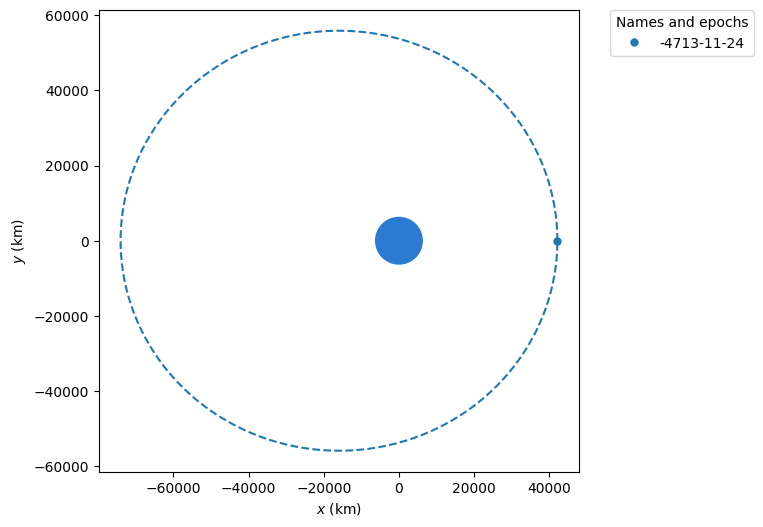

In [14]:
from poliastro.twobody.thrust import change_ecc_inc

ecc_0, ecc_f = 0.0, 0.2
a = 42164  # km
inc_0 = 0.0  # rad, baseline
inc_f = 20.0 * u.deg
argp = 0.0  # rad, the method is efficient for 0 and 180
f = 2.4e4 * (u.km / u.s**2)

k = Earth.k.to(u.km**3 / u.s**2).value
orb0 = Orbit.from_classical(
    Earth,
    a * u.km,
    ecc_0 * u.one,
    inc_0 * u.deg,
    0 * u.deg,
    argp * u.deg,
    0 * u.deg,
    epoch=Time(0, format="jd", scale="tdb"),
)

a_d, _, t_f = change_ecc_inc(orb0, ecc_f, inc_f, f)


def f(t0, state, k):
    du_kep = func_twobody(t0, state, k)
    ax, ay, az = a_d(
        t0,
        state,
        k,
    )
    du_ad = np.array([0, 0, 0, ax, ay, az])

    return du_kep + du_ad


tofs = TimeDelta(np.linspace(0, t_f, num=1000))

ephem2 = orb0.to_ephem(
    EpochsArray(orb0.epoch + tofs, method=CowellPropagator(rtol=1e-6, f=f)),
)
orb1 = Orbit.from_ephem(attractor = Earth, ephem=ephem2, epoch=orb0.epoch + t_f)


plotter = StaticOrbitPlotter()

plotter.plot(orb1)


Initial orbit: 6528 x 6528 km x 0.0 deg (GCRS) orbit around Earth (♁) at epoch J2000.000 (TT)
Lithobrake seen 1500.0 s after the beginning of de-orbit burn.


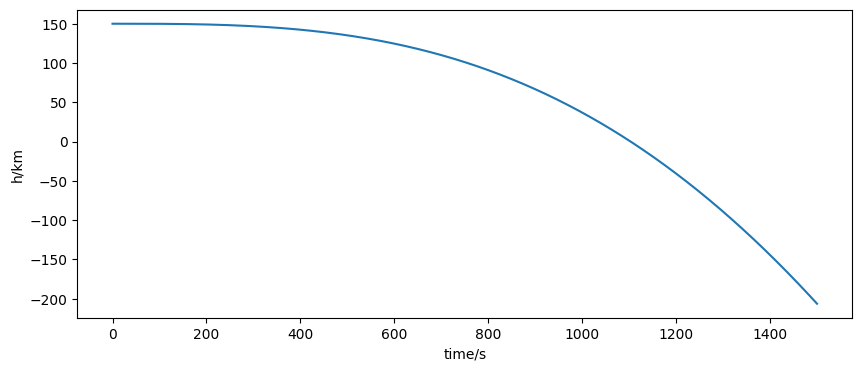

In [133]:
orb = Orbit.circular(Earth, 150 * u.km)
print(f"Initial orbit: {orb}")
# f = 2.4e4 * (u.km / u.s**2)
t_f = 1500/86400
m_wet = 1000
isp=3000 #in s (is that correct? -- no, but tbd fix)
thrust = 300 #in N
#burn acceleration function
def acc_thrust(t):
    m=m_wet - (thrust*t) / isp  
    return -0.001*thrust/m

reentry_time = []
reentry_alts = []

R = Earth.R.to_value(u.km)
# Define a threshold altitude for crossing.
thresh_alt = 0
altitude_cross_event = LithobrakeEvent(R,terminal = False)  # Set up the event.
events = [altitude_cross_event]
# print(altitude_cross_event)


def f(t0, state, k):
    du_kep = func_twobody(t0, state, k)
    v = state[3:]
    a =  acc_thrust(t0)*v/((np.linalg.norm(v)))#its in km/s lol
    alt = np.linalg.norm(state[0:3]) - R
    # print(a)
    du_ad = np.array([0, 0, 0, a[0], a[1], a[2]])
    return du_kep + du_ad

# print(type(orb.epoch+tofs))



tofs = TimeDelta(np.linspace(0, t_f, num=1000))
method=CowellPropagator(rtol=1e-6, f=f, events = events)
# print(orb.epoch+tofs[800])
ephem2 = orb.to_ephem(
    EpochsArray(orb.epoch + tofs, method)
)

ephem_alts = norm(ephem2.rv()[0],axis=1).value-R


# orb1 = Orbit.from_ephem(attractor = Earth, ephem=ephem2, epoch=orb.epoch + t_f)
# print(f"Final altitude: {np.linalg.norm(orb1.r)-R*u.km}")

# plotter = StaticOrbitPlotter()

# plotter.plot(orb)
# plotter.plot(orb1)
print(
    f"Lithobrake seen {altitude_cross_event.last_t} after the beginning of de-orbit burn."
)

fig, (ax1) = plt.subplots(1,  figsize=(10, 4))


ax1.set_ylabel("h/km")
# plt.xlabel("distance downrange, km")
ax1.set_xlabel("time/s")
#plt.xlim(12500,14000)
#plt.ylim(top = 100)
#print(reentry_alts)
# plt.ylim(150)
# print(np.shape(tofs))
ax1.plot(tofs.to(u.s),ephem_alts)

